# Notebook 3_Joining Data: Prepping and Joining Data

If you are working with the CHIS data, you aren't going to have to do any joining or merging of data.  But often, we want to bring different datasets together, which means we need to know how to merge datasets based on a common ID or "key" variable.

In today's lab, we're going to focus on

> Prepping our data for joins

> Joining by FIPS codes

As with everything in Python, there are lots of different ways to do the same thing, so we're providing some basic code so you have what you need for Assignment 4.  But you may find that when you work with your own data, you'll need to explore the web for other code.

Here are the steps we are taking in this lab:
1. Importing two datasets (Eviction Lab and ACS)
2. Cleaning the datasets (renaming columns, selecting/creating columns we want, etc.)
3. Finding the join column in both datasets and matching the formatting
4. Conducting join

## 1.0 Setup and Reading in our libraries

As a reminder, setup should *always* be the first step in your notebook, and you need to load these cells first whenever you open the file before running any other cells.

In [ ]:
# First, We're going to call in our libraries

import numpy as np
import pandas as pd
import math
from scipy import stats
import seaborn as sns
import matplotlib as plt
from datascience import *

pd.options.display.float_format = '{:.2f}'.format

In [ ]:
#Show our plots in the Jupyter notebook
%matplotlib inline

In [ ]:
#When we start working with nan (missing) values, we can get RuntimeWarning errors - we're going to ignore them here
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
pd.options.mode.chained_assignment = None  # default='warn'

## 2.0 Importing and Cleaning Eviction Lab data
First, we're going to read in our Eviction Lab data. It is publicly available here: https://data-downloads.evictionlab.org/#data-for-analysis/

In [ ]:
# Here is my code for reading in the complete evictions data and filtering it
# If you are using an area outside Alameda County for your assignment, 
# you'll want to run the lines below and alter the file location and county filter.

# data =  pd.read_csv('C:/Users/katea/Downloads/tract_proprietary_valid_2000_2018.csv')
# ac_data = data[data['county']=='Alameda County']
# ac_data.to_csv('C:/Users/katea/Downloads/AC_tract_proprietary_valid_2000_2018.csv', index = False)

#today we're just going to work with the extract
evictions00_18 = pd.read_csv('AC_tract_proprietary_valid_2000_2018.csv')
evictions00_18

### Eviction Lab Codebook
You can also find this information in the Excel sheet in DataHub, which I downloaded from the same link above.

|variable_name  |variable_type|description                                                               |
|---------------|-------------|--------------------------------------------------------------------------|
|fips           |numeric      |tract fips                                                                |
|cofips         |numeric      |county fips                                                               |
|tract          |string       |tract name                                                                |
|county         |string       |county name                                                               |
|state          |string       |state name                                                                |
|year           |numeric      |year                                                                      |
|type           |string       |OBSERVED                                                                  |
|filings        |numeric      |number of filings observed in proprietary data                            |
|filing_rate    |numeric      |number of filings per 100 renting households                              |
|threatened     |numeric      |number of households threatened with eviction observed in proprietary data|
|threatened_rate|numeric      |number of households threatened per 100 renting households                |
|judgements     |numeric      |number of judgements observed in proprietary data                         |
|judgement_rate |numeric      |number of judgements per 100 renting households                           |


### 2.1 Filtering for one year (2016)

Our data has evictions from 2000 to 2018, so let's pick a year to use.

If you did your research on the evictions dataset, you might see that California lacks a lot of data after 2016 since the state enacted an evictions masking law in 2017 making it harder to get access to evictions data (good for tenants but bad for researchers! see more here: https://www.nolo.com/legal-update/california-tenants-protected-win-eviction-lawsuits.html).

See below that there is no data for 2017 and 2018 in this Alameda County subset of the evictions data.

In [ ]:
evictions00_18['year'].value_counts()

Let's subset for just 2016 data and make a new dataframe.

In [ ]:
# note: from above we see the year is an integer64 type, so don't put quotes around 2016!
evictions16 = evictions00_18[evictions00_18['year'] == 2016]
evictions16

In [ ]:
# optional: if you're worried about an object (like a dataframe) taking up too much memory and you're done with it, you can delete it
# del evictions00_18

## 3.0 Importing and Cleaning ACS data

In [ ]:
acs16 = pd.read_csv("ACSDT5Y2016.B25070-Data.csv")
acs16

### 3.1 Dropping the first row
Remember that the censusdata has two headers, as you can see above. 

To delete the second row, we can either delete it after we load it in, or skip the second header row when we read it in.

This is a good opportunity to practice commenting out code (putting hashtags in front of each line so it doesn't run) using Ctrl/Cmd + "/". Pick an option and comment out the code in the other option.

In [ ]:
# OPTION 1 - delete a single row by index value 0
acs16 = acs16.drop(
    labels=0, # index number(s) of row(s) to drop
    axis=0 # 0 for rows (1 is for dropping columns)
)

In [ ]:
# OPTION 2 - another way to do that would have been to tell python to skip the second header row 
# (remember, Python numbering starts at 0) when you read in the data
acs16 = pd.read_csv("ACSDT5Y2016.B25070-Data.csv", skiprows = [1])
acs16

### 3.1 Selecting and Renaming Columns

We have all those MOE and annotation columns we need to get rid of. Let's select for the columns we want and assign to the same dataframe. In this case we want the GEO_ID column, the full name, and all the estimates.

In [ ]:
# This way is more intuitive / what we've done before:
# (calling each column individually)
acs16 = acs16[['GEO_ID', 'NAME', 'B25070_001E', 'B25070_002E', 'B25070_003E',
       'B25070_004E', 'B25070_005E', 'B25070_006E', 'B25070_007E',
       'B25070_008E', 'B25070_009E', 'B25070_010E', 'B25070_011E']]

# More complicated ways of doing the same thing:
# (selects if a column either ends with "E" or "GEO_ID")

#acs16 = acs16.loc[:,acs16.columns.str.endswith(('E', 'GEO_ID'))] # using endswith()
#acs16 = acs16.filter(regex='E$|GEO_ID$') # using regex

Let's rename the columns with more intuitive names.

In [ ]:
acs16 = acs16.rename(columns = {'B25070_001E':'total', 
                        'B25070_002E':'rb_less10',
                        'B25070_003E':'rb_10_15',
                        'B25070_004E':'rb_15_20',
                        'B25070_005E':'rb_20_25',
                        'B25070_006E':'rb_25_30',
                        'B25070_007E':'rb_30_35',
                        'B25070_008E':'rb_35_40',
                        'B25070_009E':'rb_40_50',
                        'B25070_010E':'rb_50plus',
                        'B25070_011E':'na'})

In [ ]:
acs16

### 3.3 Changing column types
Just like in QGIS when we had to do refactoring, the data types may have been read in wrong as strings when they should've been numeric. Let's take a look at the data.

In [ ]:
# Checking column types
acs16.info()

If you chose Option 2 beforehand and read in the data skipping the second header row, your variables should all have the correct types, but if you chose Option 1 and deleted the second header row after you read it in, your data types might be wrong.

If you need to, run this cell below to change the data types of your columns (similar to the refactoring tool in QGIS).

In [ ]:
# Here we are using a dictionary, similar to when we recoded our values in the lecture notebook
acs16 = acs16.astype({
    'total' : int,
    'rb_less10': int,
    'rb_10_15' : int,
    'rb_15_20' : int,
    'rb_20_25' : int,
    'rb_25_30' : int,
    'rb_30_35' : int,
    'rb_35_40' : int, 
    'rb_40_50' : int,
    'rb_50plus' : int,
    'na' : int
})

### 3.4 Creating aggregate variables for rent burden
Since we are more interested in the common indicator of rent burden (defining it as >30% rent burden), we need make the column by summing the rest, similar to what we did in Excel.

In [ ]:
acs16

In [ ]:
# More intuitive way
acs16['rb30plus'] = acs16['rb_30_35'] + acs16['rb_35_40'] + acs16['rb_40_50'] + acs16['rb_50plus']

# Using sum() function
#cols = ['rb_30_35','rb_35_40', 'rb_40_50','rb_50plus']
#acs16['rb30plus'] = acs16[cols].sum(axis=1)

acs16.head()

##  4.0  Joining data!

### 4.1 Matching join columns
Of course, our join will not work unless our columns are formatted the same way in terms of column type and what data is included. 

We want to match by FIPS code, but the ACS GEO_ID column looks different from the Eviction Lab FIPS one. Let's create a FIPS column for the ACS dataset with the same number of characters.

In [ ]:
# printing first few rows of each join column to see that they look different
print(acs16[['GEO_ID']].head())
print(evictions16[['fips']].head())

In [ ]:
# fixing up a fips column with the right number of characters using string subsetting
# note: ending the number 10 with a colon means we go from the 10th character to the END of the string
acs16['fips'] = acs16['GEO_ID'].str[10:]
acs16.head()

Now let's check if the join columns are the same type.

In [ ]:
print(evictions16.dtypes['fips'])
print(acs16.dtypes['fips'])

Oh no! They are different! Let's change the Eviction Lab fips column from an integer to a string / object type.

In [ ]:
evictions16['fips'] = evictions16['fips'].astype(str)

In [ ]:
# Check if it worked - this should be True
evictions16.dtypes['fips']==acs16.dtypes['fips']

### 4.2 Left join
Do you remember how joins work? We need to specify the join column via the "on" parameter and what kind of join we are doing via the "how" parameter. We already fixed up our join columns, so let's talk about what kind of join to use. This is important when not every row matches on each dataset, so you must strategically decide what rows (if any) get dropped from the result.

Here's a handy diagram of the different kinds of joins you can do.
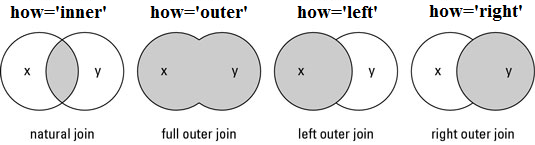

Note that in the code, the "right" dataset is the one in the parentheses, and the "left" dataset is the leftmost one.

**Left Join:** All left dataset rows kept, matching with rows from right dataset

**Right Join:** All right dataset rows kept, matching with rows from left dataset

**Inner Join:** Only rows with matches in both datasets are kept

**Outer Join:** All rows are kept, regardless if there is a match

Since our ACS dataset has data for each tract in Alameda county and there isn't necessarily evictions data for all the Alameda county tracts, we should join the evictions data to the ACS data rather than the other way around.

In [ ]:
# Result shows the eviction dataset has one less row than the ACS dataset...
print(acs16.shape)
print(evictions16.shape)

In [ ]:
# ... meaning that if we do a left join, one row of ACS data won't have a match in the eviction data.
joined = acs16.merge(evictions16, on='fips', how='left', indicator=True) # this last parameter is helpful!
joined

Using the "_merge" column that we added from the join, we can filter for rows that did not have a match.

In [ ]:
joined[joined['_merge']=='left_only']

## 5.0  That's it for now!

By lab next week Thursday, you should have selected your dataset, and 5-6 variables you plan to explore, including 1 outcome variable. Explore, clean and reclassify each variable, and come with questions!